In [1]:
"""
t3 utils fix_cantera module
A module to automatically fix issues with RMG-generated Cantera files, mainly resolving mislabeled duplicate reactions.
"""
import os

from typing import List, Optional, Union

import shutil
import time
import traceback
import yaml
import cantera as ct

class InputError(Exception):
    """Raised when an input to the Cantera-fixing utilities is invalid."""
    pass

def globalize_paths(path: str, project_directory: str) -> str:
    """
    Convert a relative path into an absolute path based on project_directory.
    If path is already absolute, return it unchanged.
    """
    if os.path.isabs(path):
        return path
    return os.path.normpath(os.path.join(project_directory, path))

def read_yaml_file(path: str,
                   project_directory: Optional[str] = None,
                   ) -> Union[dict, list]:
    """
    Read a YAML file (usually an input / restart file, but also conformers file)
    and return the parameters as python variables.

    Args:
        path (str): The YAML file path to read.
        project_directory (str, optional): The current project directory to rebase upon.

    Returns: Union[dict, list]
        The content read from the file.
    """
    if project_directory is not None:
        path = globalize_paths(path, project_directory)
    if not isinstance(path, str):
        raise InputError(f'path must be a string, got {path} which is a {type(path)}')
    if not os.path.isfile(path):
        raise InputError(f'Could not find the YAML file {path}')
    with open(path, 'r') as f:
        content = yaml.load(stream=f, Loader=yaml.FullLoader)
    return content

def to_yaml(py_content: Union[list, dict]) -> str:
    """
    Convert a Python list or dictionary to a YAML string format.

    Args:
        py_content (list, dict): The Python content to save.

    Returns: str
        The corresponding YAML representation.
    """
    yaml.add_representer(str, string_representer)
    yaml_str = yaml.dump(data=py_content)
    return yaml_str


def string_representer(dumper, data):
    """
    Add a custom string representer to use block literals for multiline strings.
    """
    if len(data.splitlines()) > 1:
        return dumper.represent_scalar(tag='tag:yaml.org,2002:str', value=data, style='|')
    return dumper.represent_scalar(tag='tag:yaml.org,2002:str', value=data)

def save_yaml_file(path: str,
                   content: Union[list, dict],
                   ) -> None:
    """
    Save a YAML file (usually an input / restart file, but also conformers file).

    Args:
        path (str): The YAML file path to save.
        content (list, dict): The content to save.
    """
    if not isinstance(path, str):
        raise InputError(f'path must be a string, got {path} which is a {type(path)}')
    yaml_str = to_yaml(py_content=content)
    if '/' in path and os.path.dirname(path) and not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    with open(path, 'w') as f:
        f.write(yaml_str)


def get_traceback(model_path: str) -> Optional[str]:
    """
    Try loading the Cantera model and return the traceback if it fails.

    Args:
        model_path (str): The path to the cantera YAML model file.

    Returns:
        Optional[str]: The traceback if the model fails to load.
    """
    tb = None
    try:
        ct.Solution(model_path)
    except ct.CanteraError:
        tb = traceback.format_exc()
    return tb


def fix_cantera(model_path: str):
    """
    Fix a Cantera model that has incorrectly marked duplicate reactions.
    Creates a backup copy of the Cantera model and fixes the content of the original file in place.

    Args:
        model_path (str): The path to the cantera YAML model file.

    Returns:
        bool: Whether the model was fixed.
    """
    shutil.copyfile(model_path, model_path + '.bak')
    done, fixed = False, False
    counter = 0
    while not done and counter < 1000:
        counter += 1
        tb = get_traceback(model_path)
        if tb is None:
            done = True
            break
        else:
            if 'Undeclared duplicate reactions detected' in tb:
                fix_undeclared_duplicate_reactions(model_path, tb)
                fixed = True
            elif 'No duplicate found for declared duplicate reaction' in tb:
                fix_no_duplicate_found(model_path, tb)
                fixed = True
            else:
                print(f'Could not fix {model_path}:\n\n{tb}')
                break
        time.sleep(1)
    if fixed:
        print(f'Fixing Cantera model {model_path} (and creating a backup copy with a .bak extension).')
    else:
        os.remove(model_path + '.bak')
    return done


def fix_undeclared_duplicate_reactions(model_path: str, tb: str):
    """
    Fix a Cantera model that has undeclared duplicate reactions.

    Args:
        model_path (str): The path to the cantera YAML model file.
        tb (str): The traceback.
    """
    content = read_yaml_file(model_path)
    rxns = get_dup_rxn_indices(tb)
    print(f'Marking reactions {", ".join([str(r) for r in rxns])} as duplicate.')
    for i in rxns:
        content['reactions'][i - 1]['duplicate'] = True
    save_yaml_file(model_path, content)


def fix_no_duplicate_found(model_path: str, tb: str):
    """
    Fix a Cantera model that has a reaction marked as duplicate by mistake with no other duplicate reaction.

    Args:
        model_path (str): The path to the cantera YAML model file.
        tb (str): The traceback.
    """
    content = read_yaml_file(model_path)
    rxns = get_mistakenly_marked_dup_rxns(tb)
    for i in rxns:
        if 'duplicate' in content['reactions'][i].keys():
            print(f'Marking reaction {i} as non-duplicate.')
            del content['reactions'][i]['duplicate']
    save_yaml_file(model_path, content)


def get_dup_rxn_indices(tb: str) -> List[int]:
    """
    Get the duplicate reactions from the traceback.

    Args:
        tb (str): The traceback.

    Returns:
        List[int]: The reactions indices.
    """
    rxns = list()
    if tb is None:
        return rxns
    lines = tb.split('\n')
    read = False
    for line in lines:
        if 'Undeclared duplicate reactions detected:' in line:
            read = True
        if '|  Line |' in line:
            break
        if read and 'Reaction' in line:
            rxns.append(int(line.split()[1].split(':')[0]))
    return rxns


def get_mistakenly_marked_dup_rxns(tb: str) -> List[int]:
    """
    Get the duplicate reactions from the traceback.

    Args:
        tb (str): The traceback.

    Returns:
        List[int]: The reactions indices.
    """
    rxns = list()
    if tb is None:
        return rxns
    lines = tb.split('\n')
    for line in lines:
        if 'No duplicate found for declared duplicate reaction number' in line:
            rxns.append(int(line.split()[8]))
    return rxns

In [2]:
fix_cantera('/home/calvin/code/RMG-Py/examples/rmg/ammonia/cantera/chem_annotated.yaml')

True

In [3]:
def get_species(gas, name):
    for s in gas.species_names:
        if s == name:        # exact match (Ar, N2, He...)
            return s
        if s.startswith(name + "("):  # RMG-style match
            return s
    raise KeyError(f"Species {name} not found.")


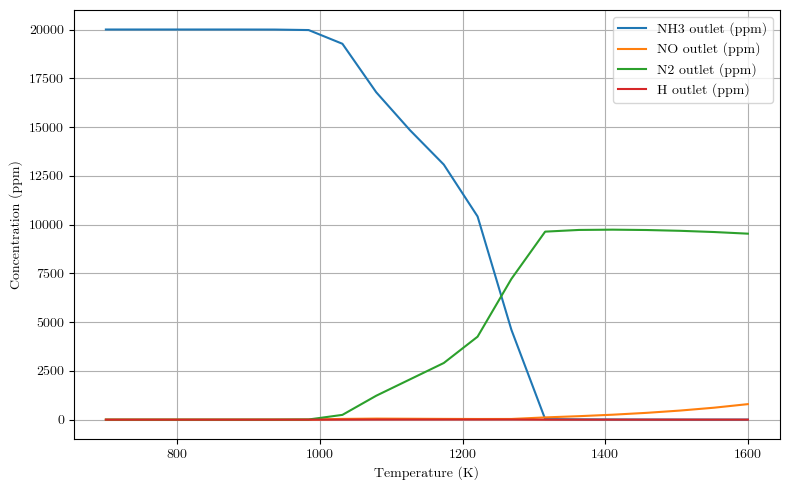

In [6]:
import cantera as ct
import numpy as np
import time
import matplotlib.pyplot as plt

# Load RMG-converted mechanism
gas = ct.Solution("/home/calvin/code/RMG-Py/examples/rmg/ammonia/cantera/chem_annotated.yaml")

# JSR volume from paper: 78 cm^3
reactor_volume = 78e-6  # m^3

# Residence time
residence_time = 3.0  # seconds

# Pressure
pressure = ct.one_atm

NH3 = get_species(gas, "NH3")
O2  = get_species(gas, "O2")
N2  = get_species(gas, "N2")
NO  = get_species(gas, "NO")
H = get_species(gas, "H2")

# Choose equivalence ratio set
inlet_phi01 = {NH3: 0.02,  O2: 0.15,  "Ar": 0.83}
# inlet_phi05 = {"NH3": 0.02,  "O2": 0.03,  "Ar": 0.95}
# inlet_phi10 = {"NH3": 0.02,  "O2": 0.015, "Ar": 0.965}

inlet = inlet_phi01   # choose φ = 0.1 for example

# Temperature sweep
T_list = np.linspace(700, 1600, 20)

NH3_out = []
NO_out  = []
N2_out  = []
H_out = []

for T in T_list:
    gas.TPX = T, pressure, inlet

    inlet_reservoir = ct.Reservoir(gas)
    outlet_reservoir = ct.Reservoir(gas)

    r = ct.IdealGasReactor(gas, energy="off", volume=reactor_volume)
    net = ct.ReactorNet([r])

    # Mass flow set to enforce τ = V / mdot
    # mdot = r.mass / residence_time
    mdot = gas.density * reactor_volume / residence_time


    mfc = ct.MassFlowController(inlet_reservoir, r, mdot=mdot)
    pr = ct.PressureController(r, outlet_reservoir, master=mfc)


    net.advance(residence_time)

    # Extract steady-state outlet composition
    NH3_out.append(r.thermo[NH3].X[0])
    NO_out.append(r.thermo[NO].X[0])
    N2_out.append(r.thermo[N2].X[0])
    H_out.append(r.thermo[H].X[0])


NH3_ppm = [x * 1e6 for x in NH3_out]
NO_ppm  = [x * 1e6 for x in NO_out]
N2_ppm  = [x * 1e6 for x in N2_out]
H_ppm = [x * 1e6 for x in H_out]

plt.figure(figsize=(8,5))
plt.plot(T_list, NH3_ppm, label="NH3 outlet (ppm)")
plt.plot(T_list, NO_ppm,  label="NO outlet (ppm)")
plt.plot(T_list, N2_ppm,  label="N2 outlet (ppm)")
plt.plot(T_list, H_ppm,  label="H outlet (ppm)")
plt.xlabel("Temperature (K)")
plt.ylabel("Concentration (ppm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
